# Loop Service - Exaggerated Income Analysis 

### Summary
This document outlines an apporach to targeting exaggerated incomes in applications to the Loop Service.  This approach uses data-driven techniques to identify important characteristics for understanding how income relates to other factors in the data and using this to find unusual applications.

### Why does this analysis add value?

* Loaning to people who exaggerate their income on an application could lead to extending loans to those less able to repay.

* It costs to verify applications and finding a data-driven mechanism to prioritise suspect applications would provide a more cost-effective way to verify.

* Historically, a small fraction of loans have been left with no verification status (0.5%) while 28.7% have been specifically marked 'unverified'
* There is a slightly higher proportion of applications in the incoming stream that have been unverified or have no verification designation at all than in the baseline application data
* The no-status applicants are riskier based on default/charge-off rate


|Metric| **Overall**      | **Unverified** |  **No-Status** |
|---|------------------|----------------|----------------|
| historical, # of loans |636,687 | 182,448 | 3180|
| historical, % of loans |100 % | 28.7% | 0.5%|
| historical value |\$9.62B | \$2.17B | \$48M |
| stream, # of loans | 311,200 | 96,100 | 3150|
| stream, % of loans | 100% | 30% | 1% |
| stream value (est) |\$4.70B | \$1.14B | \$47.5M |
| default/charge-off | 8.5% | 6% | 10% |

* Finding a way to indicate if these no-status applicants should go through the verification process would allow Lending Club to mitigate that risk in a cost-effective way


### Approach
* Establish an income distribution baseline, relating income to other variables on the application
  
  * Records with missing income or loan amount data were removed, assuming that these are incomplete applications
  * Records with missing values in other columns were replaced with either 0s (numeric) or "unknown" (categorical), assuming missing numeric data indicated applicants didn't have the specified existing credit accounts questions were asking about
  * Important variables are identified using a random forest variable importance ranking
  * The income distribution model built from the baseline uses a decision tree fit on the most important variables related to income
  * The decision tree technique was chosen:
      * to bypass issues of multicollinearity which would have been a challenge for OLS
      * for interpretability
      * because it is quick to fit
* Ensure the income distribution baseline only relies on data which applicants will supply prior to receiving a loan decision
* Use the income distribution baseline to generate estimates for the new applicants and compare to their stated annual income figures
* Idenfity any unusual cases, focussing on the unverified and no-status applications

### Preliminary Results

* The most important variables identified were related to existing credit the applicant already had and their homeowner status
* 'No-status' applications are ~\$1600 over the baseline estimate on average
* There are 819 applications which are extreme outliers (using a 1.5*IQR + 75th Percentile definition) - all of these have no verification status listed - this could be worth ~\$9M if loan amounts reflect historical averages
* Unverified applications are approximately in line with  expectations

### Limitations
* The income distribution baseline model could be improved by sourcing in data from applicants who were denied as well - since these are missing, the model for income is biased towards just people who have sufficient income and credit to have been granted loans.
* I've dropped variables with >52 categories, since the tree-based models in R restrict at this cutoff. This means we can't use job title, for instance.
* More powerful computing resources could improve the model choice, enabling the use of a more sophisticated modelling technique
* Further detailed feature analysis could reveal better ways of exploiting the existing data set
* To hone in on the verification issue in more detail, it would be interesting to see how many verifications uncover that people need to amend their application details

### Proposed roadmap for further improvement
Short term:
* Mapping in data from a wider population including rejected applicants could be done right away; this data is available online.  This will improve the income distribution estimates, making us more confident that outliers are really exaggerated.
* Deploying this analysis on a VM with better compute resources can also be done right away. This will improve the suite of models that can be explored - larger Random Forests or Gradient-boosting, etc. This would improve the model choices, so potentially more accurate models can be fit.
* Research the variables in greater detail, making a more conscious decision about how to include it in the model. This could improve the model predictions.
    * Run a text-based analysis on the variables with more than 52 categories to reduce them into reasonable groups.  

Long term: 
* A long-term improvement would be to assess if there are other questions that should be asked to understand income. This could also improve quality of model predictions.
* Understanding the process of verification could feed into whether it is possible to measure incidence rates of exaggeration - but this is a bigger process change and is sensitive

### Analysis code
* Analysis is implemented in R, using the dplyr package (and wider tidyverse package family) for data cleansing and tree-based methods (packages: rpart, randomForest) for variable importance ratings and model-fitting

#### Step 0:  Enabling an R-Kernel in Jupyter
* Instructions for enabling R in a Jupyter notebook can be found here if needed:  https://github.com/IRkernel/IRkernel
* I also needed to ensure that the file location for the Python kernel used for Jupyter was added to the PATH environment variable so R could see it

#### Step 1:  Load data and packages

In [113]:
## Extract Zip-files to CSV format. Save in Data folder.
baseline_zip_file <- "../Data/baseline.csv.zip"
unzip(baseline_zip_file,exdir = "../Data")

stream_zip_file <- "../Data/stream.csv.zip"
unzip(stream_zip_file,exdir = "../Data")


In [1]:
## Install any required R Packages
packages <- c("readr","dplyr","stringr","tidyr","randomForest","rpart","ggplot2","corrplot")
install.packages.set.repos <- function(package_name){
    install.packages(package_name, repos="https://cloud.r-project.org")
}
s <- suppressWarnings(
lapply(packages,install.packages.set.repos)
    )

package 'readr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\katelyn.weber\AppData\Local\Temp\Rtmpyu94N7\downloaded_packages
package 'dplyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\katelyn.weber\AppData\Local\Temp\Rtmpyu94N7\downloaded_packages
package 'stringr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\katelyn.weber\AppData\Local\Temp\Rtmpyu94N7\downloaded_packages
package 'tidyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\katelyn.weber\AppData\Local\Temp\Rtmpyu94N7\downloaded_packages
package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\katelyn.weber\AppData\Local\Temp\Rtmpyu94N7\downloaded_packages
package 'rpart' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\katelyn.weber\AppData\L

In [2]:
## Load packages
packages <- c("readr","dplyr","stringr","tidyr","randomForest","rpart","ggplot2","corrplot")
s <- suppressWarnings(
lapply(packages,library,character.only = TRUE)
    )


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin

corrplot 0.84 loaded


In [116]:
## Read in the data
baseline <- read_csv(file = "../Data/baseline.csv") %>%
    rename(id = X1)
stream <- read_csv(file = "../Data/stream.csv") %>%
    rename(id = X1)

Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  desc = col_character(),
  open_il_6m = col_character(),
  earliest_cr_line = col_character(),
  revol_util = col_character(),
  open_il_24m = col_character(),
  term = col_character(),
  max_bal_bc = col_character(),
  open_rv_24m = col_character(),
  addr_state = col_character(),
  emp_title = col_character(),
  total_bal_il = col_character(),
  loan_status = col_character(),
  il_util = col_character(),
  home_ownership = col_character(),
  title = col_character(),
  mths_since_rcnt_il = col_character(),
  grade = col_character(),
  pymnt_plan = col_character(),
  issue_d = col_character()
  # ... with 12 more columns
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  desc = col_character(),
  verification_status = col_character(),
  issue_d = col_character(),
  addr_state = col_character(),
  emp_title = co

#### Step 2:  Clean data

In [117]:
## Update the baseline data to remove missing annual income and loan amount records
## Assumption:  these are not completed applications
baseline <- baseline %>% 
  filter(!is.na(annual_inc)) %>%
  filter(!is.na(loan_amnt))

## Count the records remaining
N <- baseline %>% tally()
N


n
636687


#### Step 3:  Investigate data - provide stats for high-level summary

In [118]:
## Data by verification status

verification_table <- baseline %>%
  group_by(verification_status) %>%
  summarise(total_amnt = sum(loan_amnt),
            number_applications = n(),
            avg_dti = mean(dti,na.rm=T),
            avg_income = mean(annual_inc),
            med_income = median(annual_inc),
            avg_loan_amnt = mean(loan_amnt)) %>%
 mutate(app_freq = number_applications/sum(number_applications)) %>%
 mutate(amnt_freq = total_amnt/sum(total_amnt))

verification_table

verification_status,total_amnt,number_applications,avg_dti,avg_income,med_income,avg_loan_amnt,app_freq,amnt_freq
Not Verified,2166361000,182448,18.15883,69068.79,60000,11873.85,0.286558387,0.225250015
Source Verified,4232460225,267659,18.42333,79084.60,65000,15812.88,0.420393380,0.440075191
Verified,3170758500,183400,19.77023,79199.47,68000,17288.76,0.288053628,0.329683465
NA,48004525,3180,18.69426,76343.33,65000,15095.76,0.004994605,0.004991329


In [119]:
## Default or Charged Off loans by verification status
verification_default_table <- baseline %>%
 filter(loan_status=="Default"|loan_status=="Charged Off")%>%
  group_by(verification_status) %>%
  summarise(total_amnt = sum(loan_amnt),
            number_applications = n(),
            avg_dti = mean(dti,na.rm=T),
            avg_income = mean(annual_inc),
            avg_loan_amnt = mean(loan_amnt))

verification_default_table

verification_status,total_amnt,number_applications,avg_dti,avg_income,avg_loan_amnt
Not Verified,131727075,11540,19.45781,61487.16,11414.82
Source Verified,368693725,23452,20.11493,69663.60,15721.21
Verified,329398575,18987,21.27249,71618.33,17348.64
NA,4827325,318,19.94098,68417.20,15180.27


In [120]:
## Total values for entire portfolio
verification_table %>%
    inner_join(verification_default_table,by=c("verification_status")) %>%
        mutate(all = "all") %>%
    group_by(all) %>%
    summarise(default_prop = sum(number_applications.y)/sum(number_applications.x),
              default_amnt_prop = sum(total_amnt.y)/sum(total_amnt.x),
              default_amnt = sum(total_amnt.y),
              total_loan_amnt = sum(total_amnt.x))


all,default_prop,default_amnt_prop,default_amnt,total_loan_amnt
all,0.08528052,0.0867834,834646700,9617584250


In [121]:
## Incoming stream of applications for comparison
## Remove missing income data from stream dataset

stream <- stream %>% 
  filter(!is.na(annual_inc))

stream %>%
  group_by(verification_status) %>%
  summarise(
            number_applications = n(),
            avg_dti = mean(dti,na.rm=T),
            avg_income = mean(annual_inc,na.rm=T),
            med_income = median(annual_inc,na.rm=T)) %>%
  mutate(prop_n = number_applications/sum(number_applications))

stream %>% tally()

verification_status,number_applications,avg_dti,avg_income,med_income,prop_n
Not Verified,96100,18.60080,78292.39,70000,0.30880463
Source Verified,125184,17.24022,82631.79,67000,0.40226221
Verified,86766,20.26836,76837.25,64496,0.27881105
NA,3150,18.52987,78857.83,67000,0.01012211


n
311200


In [122]:
## Variable selection
## Top-down rules:
## - remove any information that we would not know prior to granting loan
## - remove any information directly tied to income, e.g. DTI
## - remove any ratios, which are inherently related to other vars in set

## Select just numeric data
baseline_numeric <- baseline %>% 
  select(which(sapply(., is.numeric))) %>%
  select(-dti,-loan_amnt,-funded_amnt,-funded_amnt_inv,-bc_util,-recoveries) %>% ## remove fields not available in new apps
  replace(is.na(.), 0) %>% ## fill in missing data
  arrange(id) %>%
  select(-id)


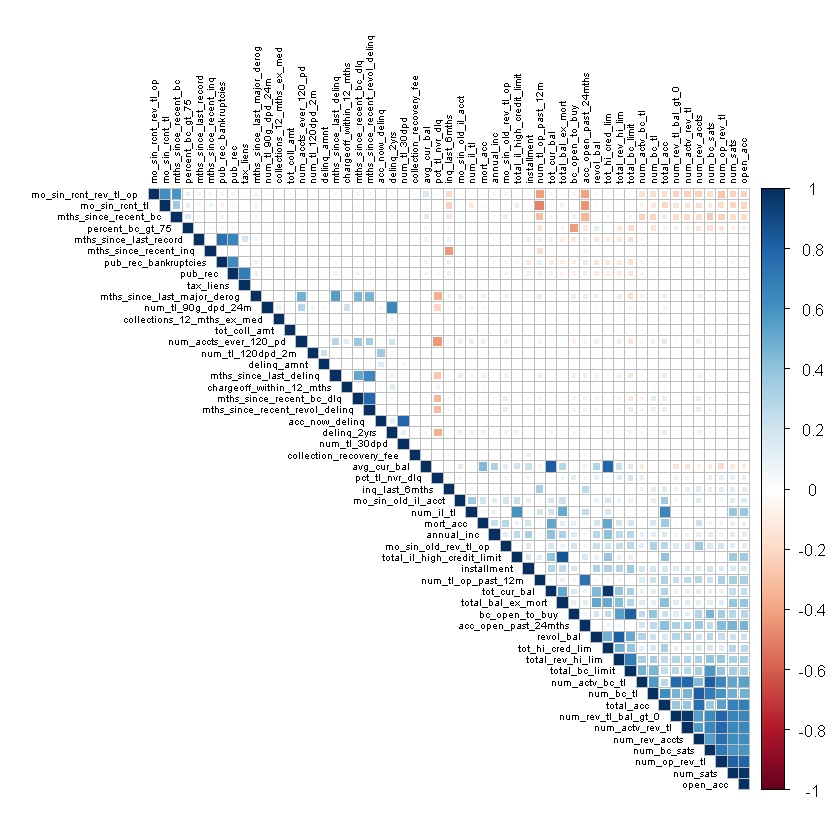

In [123]:
cor_matrix <- cor(baseline_numeric,use="pairwise")
corrplot(cor_matrix,tl.cex=.5,tl.col=1,type="upper",method="square",order="FPC")
## indicates that as expected multicollinearity is present

In [124]:
## On read, R misclassified several numeric columns, which are converted here
baseline_mistyped <- baseline %>%
  select(total_bal_il, max_bal_bc, revol_util, mths_since_rcnt_il, il_util, 
         all_util, open_acc_6m, open_rv_12m, open_rv_24m, inq_last_12m,
         total_cu_tl,open_il_6m, open_il_12m, open_il_24m, inq_fi) %>%
  mutate(revol_util = gsub("%","",revol_util,fixed=T)) %>%
  mutate_all(as.numeric) %>% ## convert to numeric
  replace(is.na(.), 0) ## clean up missing values, replacing with 0

baseline_factor <- baseline %>%
  select(which(sapply(., is.character))) %>%
  select(-int_rate,-total_bal_il, -max_bal_bc, -revol_util, -mths_since_rcnt_il, 
         -il_util, -all_util, -open_acc_6m, -open_rv_12m, -open_rv_24m, 
         -inq_last_12m,-total_cu_tl,-open_il_6m, -open_il_12m, -open_il_24m, -inq_fi) %>%
  select(-loan_status,-grade) %>% ## removed because it is not in the streaming set
  select(-zip_code,-earliest_cr_line) %>% ## removed because randomForest has structural limitation with diverse categorical variables
  replace(is.na(.),"unknown") %>% ## clean up missing data
  mutate(emp_title = toupper(emp_title)) %>% ## clean up free-entry job-title field (a little)
  mutate_all(as.factor) ## convert to factor - categorical variable data type

## Recombine the typed datasets
baseline_for_model <- bind_cols(baseline_numeric,baseline_factor,baseline_mistyped) %>%
  select(-desc,-term,-emp_title,-title,-pymnt_plan,-installment)

## Do the same for the stream data
stream_numeric <- stream %>% 
  select(which(sapply(., is.numeric))) %>%
  select(-dti,-bc_util) %>%
  replace(is.na(.), 0)

stream_mistyped <- stream %>%
  select(revol_util) %>%
  mutate(revol_util = gsub("%","",revol_util,fixed=T)) %>%
  mutate_all(as.numeric) %>%
  replace(is.na(.), 0)

stream_factor <- stream %>%
  select(which(sapply(., is.character))) %>%
  select(-revol_util) %>%
  replace(is.na(.),"unknown") %>%
  mutate(emp_title = toupper(emp_title)) %>%
  mutate_all(as.factor)

stream_for_model <- bind_cols(stream_numeric,stream_factor,stream_mistyped)

In [125]:
## Variable importance using random forest
## Due to memory constraints on my laptop, I've had to reduce the size of each tree and number of trees
## this could be 'beefed up' in a v2
set.seed(1)
rf <- randomForest(annual_inc ~ ., data = baseline_for_model, ntree=250, maxnodes=4)
var_imp <- rf$importance[sort.list(rf$importance,decreasing=TRUE),]
var_imp[var_imp > 0]

## Forms the model of the most important columns found via the random forest method and the 
## specific variables 'purpose', 'verification_status', and 'emp_length' based on conversation with Andrew
model_call = as.formula(paste("annual_inc ~ ",
             paste(unique(c(names(rf$importance[rf$importance>0,]),"purpose","verification_status","emp_length")),
                                                    collapse="+")))

tot_hi_cred_lim                tot_cur_bal 
              1.433266e+14               1.134335e+14 
         total_bal_ex_mort                  revol_bal 
              4.750423e+13               2.456892e+13 
          total_rev_hi_lim                avg_cur_bal 
              1.846554e+13               1.574385e+13 
            total_bc_limit total_il_high_credit_limit 
              8.232892e+12               6.850110e+12 
                  mort_acc             home_ownership 
              3.899175e+12               4.365245e+11 
       verification_status                   num_sats 
              1.933754e+11               1.897579e+11 
                  open_acc       mo_sin_old_rev_tl_op 
              1.854497e+11               1.312818e+11 
            bc_open_to_buy                 addr_state 
              3.341289e+10               2.514692e+10

#### Step 4:  Create income distribution model

In [126]:
## Fit a regression tree model
# Preferential because of interpretability and compute resources
rpart_fit <- rpart(model_call, data = baseline_for_model, control = rpart.control(cp = 0.001)) 

## drop the cp to get a more complex tree

#### Step 5:  Generate income estimates on new applicants

In [127]:
## Add residuals and predictions from regression tree to the data stream
stream_for_model <- stream_for_model %>%
  mutate(pred_rpart = predict(rpart_fit,newdata=stream_for_model)) %>%
  mutate(resid_rpart = annual_inc - predict(rpart_fit,newdata=stream_for_model))

## Print the average residual for each verification status
stream_for_model %>%
  group_by(verification_status) %>%
  summarise(avg_resid = mean(resid_rpart,na.rm=T))

verification_status,avg_resid
Not Verified,-313.2966
Source Verified,6802.2108
unknown,1662.0377
Verified,-201.5933


#### Step 6:  Rank new applicants against expectations

In [128]:
## Identify outliers using Boxplot methodology (outlier = 75th percentile + 1.5*IQR)
## Count the outliers
stream_for_model %>%
  filter((verification_status == "unknown" | verification_status == "Unverified") 
         & resid_rpart > quantile(resid_rpart) + 1.5*IQR(resid_rpart)) %>%
  tally()

## Print the outliers
stream_for_model %>%
  filter((verification_status == "unknown" | verification_status == "Unverified") 
         & resid_rpart > quantile(resid_rpart) + 1.5*IQR(resid_rpart)) %>%
  select(id,purpose,verification_status,annual_inc,pred_rpart,resid_rpart) %>%
  arrange(desc(resid_rpart))

n
819


id,purpose,verification_status,annual_inc,pred_rpart,resid_rpart
748098,credit_card,unknown,700000,356763.46,343236.5
808815,credit_card,unknown,393000,139696.90,253303.1
800570,unknown,unknown,685000,445874.15,239125.8
976293,debt_consolidation,unknown,275000,57352.27,217647.7
880557,debt_consolidation,unknown,412523,197573.19,214949.8
961616,home_improvement,unknown,300000,85532.57,214467.4
970073,credit_card,unknown,350000,139696.90,210303.1
847885,debt_consolidation,unknown,338000,128783.62,209216.4
854778,debt_consolidation,unknown,280000,79318.44,200681.6
713666,debt_consolidation,unknown,300000,104212.57,195787.4
